In [2]:
# Import required libraries and set folder path
import pandas as pd
import numpy as np
import os,sys,re
from sklearn.feature_extraction.text import TfidfVectorizer
os.chdir('C:/Users/arpit.goel/Documents/Projects/Kaggle/28_ResearchMatch/')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from itertools import product
ps = PorterStemmer()
stop_words=set(stopwords.words('english'))

validation_sets=[999]
# validation_sets=[5,8]
neg_sampling_ratio=0.1
th=0.275

def clean_text(x):
    x=str(x).lower()
    x=re.sub('[^a-z ]+', ' ',x)
    x=' '.join([ps.stem(y) for y in x.split(' ') if y not in stop_words])
    return x

#Import all rawdata
df_info_train=pd.read_csv('01.RawData/information_train.csv',delimiter='\t',parse_dates=['pub_date'],index_col=['pmid'])
df_info_test=pd.read_csv('01.RawData/information_test.csv',delimiter='\t',parse_dates=['pub_date'],index_col=['pmid'])
df_train=pd.read_csv('01.RawData/train.csv')
df_test=pd.read_csv('01.RawData/test.csv')
df_subm=pd.read_csv('01.RawData/sample_submission_eSUXEfp.csv')

#Parse the citations
df_train['ref_list_parse']=df_train['ref_list'].map(lambda x: map(int,re.sub('[^0-9,]','',x).split(',')))
df_train['num_citations']=df_train['ref_list_parse'].map(lambda x: len(x))

# Make flat file for citation indicator
def get_citation_master(df1,df2):
    citation_master=df1[['set','pub_date']].reset_index()
    citation_master=pd.merge(citation_master,citation_master,on=['set'],suffixes=['','_citation'])
    citation_master=citation_master[citation_master['pmid']!=citation_master['pmid_citation']]
    citation_master['sample']='test'
    if 'num_citations' in df2.columns:
        citation_master['sample']='train'
        citations=[pd.Series(x[1]['ref_list_parse'],index=[x[1]['pmid']]*x[1]['num_citations']) for x in df_train.iterrows()]
        citations=pd.concat(citations).to_frame('pmid_citation')
        citations.index.name='pmid'
        citations=citations.reset_index()
        citations['flag_citation']=1
        citations['pmid_citation'] = pd.to_numeric(citations.pmid_citation, errors='ignore')
        citation_master=pd.merge(citation_master,citations,how='left',on=['pmid','pmid_citation'])
        citation_master['flag_citation']=citation_master['flag_citation'].fillna(0)
    citation_master.drop(['keep1','keep2','random'],axis=1,inplace=True,errors='ignore')
    return citation_master

master_train=get_citation_master(df_info_train,df_train)
master_test=get_citation_master(df_info_test,df_test)
master=pd.concat([master_train,master_test])
master_info=pd.concat([df_info_train,df_info_test])
master_info['snum']=np.arange(len(master_info))
master_info['abstract_article_title']=master_info['article_title']+' '+master_info['abstract']


In [3]:
#Make feature for common authors
authors=master_info['author_str'].map(lambda x: set(str(x).split(',')))
master['t_authors']=master['pmid'].map(authors)
master['t_authors_citation']=master['pmid_citation'].map(authors)
master['t_num_authors']=master['t_authors'].map(lambda x: len(x))
master['f_num_common_authors']=master[['t_authors','t_authors_citation']].apply(lambda x:len(x[0].intersection(x[1])),axis=1)
master=master[((master['f_num_common_authors']>0) |(master['pub_date']>=master['pub_date_citation']))]
master.drop(['t_authors','t_authors_citation','t_num_authors'],axis=1,inplace=True)
#Make variable for datediff
master['f_date_diff']=(master['pub_date']-master['pub_date_citation']).dt.days

In [4]:
#Make variables based on text similarities
def get_text_similarities(col):
    master_info[col]=master_info[col].map(clean_text)
    tfidf_vectorizer = TfidfVectorizer(max_df=0.2,min_df=0.0)
    tfidf_vectorizer.fit(master_info[col])
    print col,len(tfidf_vectorizer.vocabulary_.keys())
    matrix1=tfidf_vectorizer.transform(master['pmid'].map(master_info[col]))
    matrix2=tfidf_vectorizer.transform(master['pmid_citation'].map(master_info[col]))
    matches=matrix1.multiply(matrix2)
    master['f_max_%s'%col]=matches.max(axis=1).toarray()[:,0]
    master['f_sum_%s'%col]=np.array(matches.sum(axis=1))
    master['f_cnt_%s'%col]=np.array((matches>0).sum(axis=1))

get_text_similarities('article_title')
get_text_similarities('abstract')
get_text_similarities('abstract_article_title')

#Make train validation split
train=master[master['sample']=='train']
test=master[master['sample']=='test']


article_title 6137
abstract 18254
abstract_article_title 18577


In [6]:
from sklearn.tree import DecisionTreeClassifier
idv=[x for x in train.columns if x[:2]=='f_']
clf=DecisionTreeClassifier(max_depth=5, min_samples_split=200, min_samples_leaf=100,random_state=1234)
clf.fit(train[idv],train['flag_citation'])


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=100,
            min_samples_split=200, min_weight_fraction_leaf=0.0,
            presort=False, random_state=1234, splitter='best')

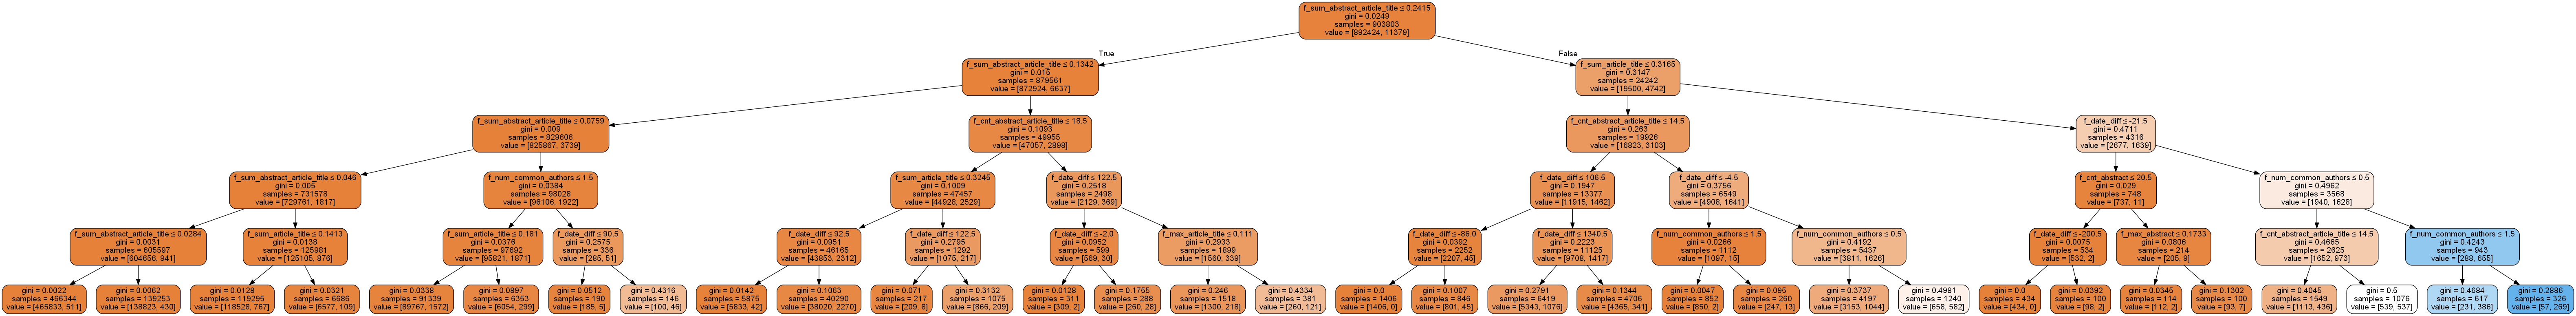

In [7]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()

export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names=idv)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [10]:
test.loc[:,'score']=clf.predict(test.loc[:,idv].fillna(0))
test.loc[:,'predict']=clf.predict_proba(test.loc[:,idv].fillna(0))[:,1]
test.loc[:,'rank']=test.groupby('pmid')['predict'].rank(ascending=False)
output=test[((test.loc[:,'score']==1)|(test.loc[:,'rank']==1))]
output['pmid_citation']="'"+output['pmid_citation'].astype(str)+"'"
output=output.groupby(['pmid'])['pmid_citation'].apply(lambda x: '['+','.join(x)+']')
df_subm['ref_list']=df_subm['pmid'].map(output).fillna('['+df_subm['pmid'].astype(str)+']')
df_subm[['pmid','ref_list']].to_csv('02.Submission/11.Predict2.csv',index=False)


test['ans'] = clf.predict(test[idv].fillna(0))


prob_score = clf.predict_proba(test[idv].fillna(0))
prob_score = pd.DataFrame(prob_score)
prob_score.index = test.index
test['score'] = prob_score[1]
results1 = test[test.ans==1]
results1 = results1[['pmid','pmid_citation','score']]
pmid_results1 = list(results1.pmid.unique())
pmid_results1 = pd.DataFrame(pmid_results1)
pmid_results1.columns = ['pmid']
pmid_results1['flag'] = 1

output=test.sort_values(by=['pmid','score'],ascending=[0,0])
output=output[['pmid','pmid_citation','score']].drop_duplicates(subset=['pmid'])
output=pd.merge(output,pmid_results1,how='left',on=['pmid'])
output['flag']=output['flag'].fillna(0)

results2 = output[output.flag==0]
final_results=pd.concat([results1[['pmid','pmid_citation','score']],results2[['pmid','pmid_citation','score']]])


final_results.set_index('pmid',inplace=True)
final_results['pmid_1']=final_results['pmid_citation'].map(lambda x: "'%d'"%x)
df_subm['pmid_o']=df_subm['pmid'].map(lambda x: "['%d']"%x)

a2 = final_results.groupby('pmid')['pmid_1'].apply(list)
a2 = a2.reset_index()
a2.columns = ['pmid','ref_list']
a2.set_index('pmid',inplace=True)
df_subm['ref_list']=df_subm['pmid'].map(a2['ref_list']).fillna(df_subm['pmid_o'])

df_subm[['pmid','ref_list']].to_csv('02.Submission/11.Predict2.csv',index=False)

C:\Users\arpit.goel\AppData\Local\Continuum2\Anaconda2\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\arpit.goel\AppData\Local\Continuum2\Anaconda2\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\arpit.goel\AppData\Local\Continuum2\Anaconda2\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us